In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5)
from datetime import datetime#, timedelta
import sys
sys.path.append('../')
from utils import db_utils
from utils import iefp_data_utils

In [2]:
# connect to db and read tables
conn = db_utils.connect_to_db()
movements = db_utils.read_table(conn, 'cascais_v2', 'movement')
applications = db_utils.read_table(conn, 'cascais_v2', 'application')
cancellations = db_utils.read_table(conn, 'cascais_v2', 'cancellation')
interventions = db_utils.read_table(conn, 'cascais_v2', 'intervention')
convocations = db_utils.read_table(conn, 'cascais_v2', 'convocation')
interviews = db_utils.read_table(conn, 'cascais_v2', 'interview')

In [3]:
# Map variables to usable versions
applications = iefp_data_utils.map_variables(applications)

# Filter data to represent what we use for analysis
apps_min_date = '1980-01-01'
apps_max_date = '2015-04-30'
applications = iefp_data_utils.clean_applications(applications,apps_min_date,apps_max_date)

movs_min_date = '1980-01-01'
movs_max_date = '2017-06-01'
movements = iefp_data_utils.clean_movements(movements, movs_min_date,movs_max_date, applications['table_index'])

## 1. Null analysis

In [4]:
# Show how many of each demographic field is Null. Uncomment last line to see
null_count = applications.isnull().sum().sort_values(ascending=False)
#null_count

## 2. Education attainment by age

/opt/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


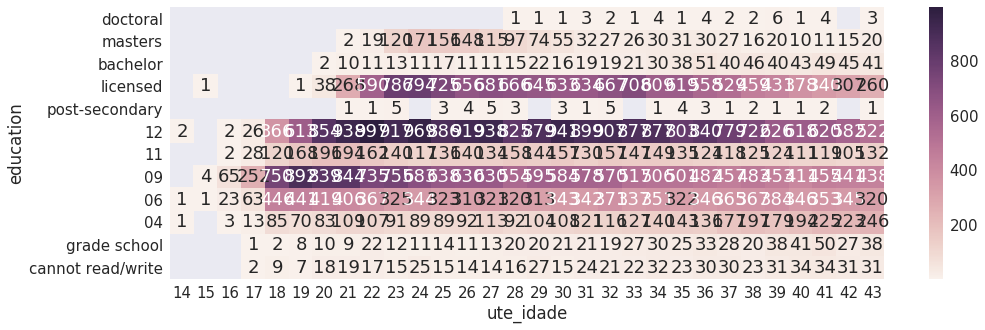

In [5]:
# See number of apps submitted for each education level by age. Check that there aren't really young people getting doctorates
#Create age v. education DataFrame and sort on education level
edu_age = DataFrame(applications.groupby(['ute_idade', 'education']).ute_id.count())
edu_age = edu_age.reset_index().pivot('education', 'ute_idade', 'ute_id')
edu_order = ['cannot read/write', 'grade school', 
            '04', '06', '09', '11', '12', 'post-secondary', 'licensed',
            'bachelor', 'masters', 'doctoral']
edu_age = edu_age.reindex(index = edu_order[::-1])

#plot number of apps, up to the first 30 ages
fig, ax = plt.subplots(figsize = (16,5))
sns.heatmap(edu_age.iloc[:, :30], annot=True, fmt='g', ax=ax)

## 3. Double new registrations

In [6]:
#Check that the percent of users that have multile new registrations is very low
print "Number of applications that are re-reg (S) vs. new reg (N)"
print applications.candidatura_rinsc.value_counts()

print "\nPercent of users that have n applications that are new reg"
num_new_reg = DataFrame(applications[applications['candidatura_rinsc']=='N'].ute_id.value_counts().sort_values(ascending=False))
num_new_reg.ute_id.value_counts(normalize=True)

Number of applications that are re-reg (S) vs. new reg (N)
S    66664
N    29724
Name: candidatura_rinsc, dtype: int64

Percent of users that have n applications that are new reg


1    0.999091
2    0.000909
Name: ute_id, dtype: float64

## 5. Discrepencies between application date and anomes

In [7]:
#Check how often year_month is different from anomes, and check that anomes always occurs after the date (difference is positive)

def date_differences(df, anomes, date, xNum):
    dates = df[[anomes, date]]
    
    #make datetime objects of anomes and date
    dates.loc[:,'trunc_date'] = pd.to_datetime(dates.loc[:,date].str[:7],format='%Y-%m', errors='coerce')
    dates.loc[:,'year_month'] = pd.to_datetime(dates.loc[:,anomes].astype(str), format='%Y%m', errors='coerce')
    
    #calculate difference and round to nearest month
    dates.loc[:,'difference'] = dates.loc[:,'year_month']-dates.loc[:,'trunc_date']
    dates.loc[:,'month_difference'] = (dates.loc[:,'difference']/np.timedelta64(1, 'M'))
    dates.loc[:,'month_difference'] = dates.loc[:, 'month_difference'].round()
    
    #plot
    plt.figure(figsize=(10,3))
    plt.xlabel("anomes - movement_event_date")
    plt.ylabel("percent of apps")
    plt.title("Top "+str(xNum)+" month differences")
    dates.month_difference.value_counts(dropna=False, normalize=True).head(xNum).sort_index().plot(kind='bar')

    return dates

/opt/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


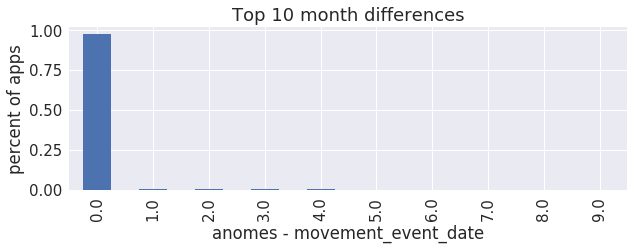

In [8]:
app_dates = date_differences(applications, 'anomes', 'candidatura_data', 10)

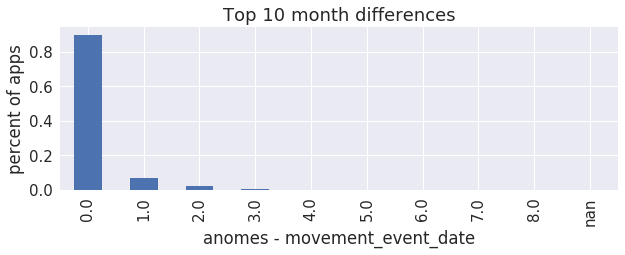

In [9]:
cancel_dates = date_differences(cancellations, 'anomes', 'anulacao_data', 10)

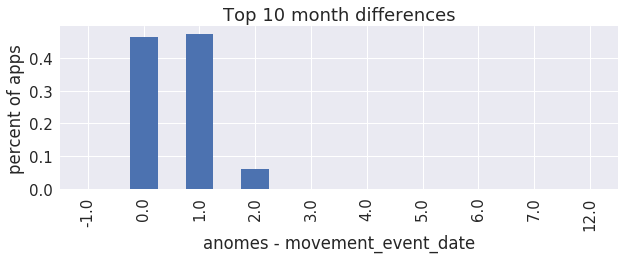

In [10]:
interview_dates = date_differences(interviews, 'anomes', 'apresentacao_data', 10)

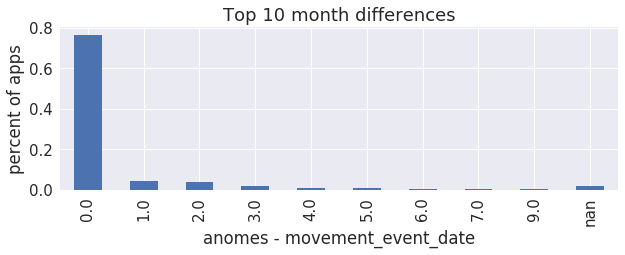

In [11]:
intervention_dates = date_differences(interventions, 'anomes', 'intervencao_data', 10)

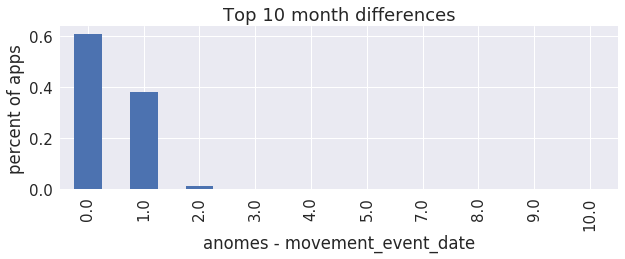

In [12]:
convocation_dates = date_differences(convocations, 'anomes', 'convocatoria_em', 10)

## 6. Reasons for cancellation by year

In [13]:
movements.loc[:, 'year'] = movements.loc[:, 'movement_event_date'].map(lambda x: x.year)

In [14]:
cancel_reasons = DataFrame(movements[movements['movement_type']=='cancellation'].groupby(['year','movement_subtype']).count())
cancel_reasons = cancel_reasons.unstack(level=-1)
cancel_reasons = cancel_reasons.xs('ute_id', axis=1, drop_level=True)
cancel_reasons.loc[:, 'total'] = cancel_reasons.sum(axis=1)
cancel_reasons.sort_values(by = 2017, ascending=False, axis=1, inplace=True)

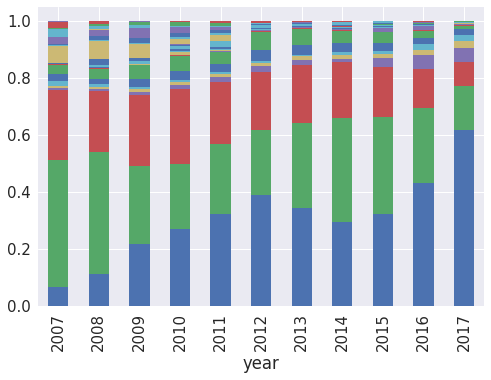

In [15]:
cancel_reasons.div(cancel_reasons.loc[:, 'total'], axis=0).drop('total', axis=1).plot.bar(stacked=True, legend=False)


/opt/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


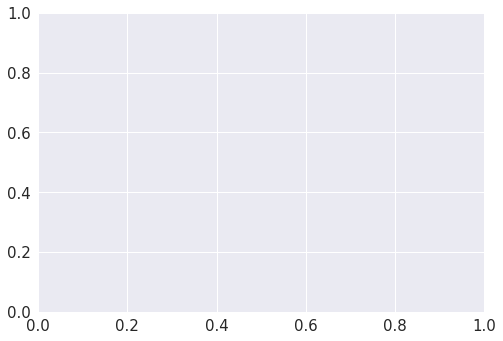

In [16]:
plt.legend()

## 